In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import sys
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
path = Path(os.getcwd())

In [3]:
base_dir = path.parent.parent

In [4]:
# Import the prewritten helper functions 
from py_helper_functions import *

In [5]:
#Windows format
data_in = os.path.join(str(base_dir) , "da_data_repo\\bisnode-firms\\clean\\")
data_out = os.path.join(str(base_dir) , "da_data_repo\\bisnode-firms\\")
output = os.path.join(data_out,'output')
func = os.path.join(str(base_dir) ,   "da_case_studies\\ch00-tech-prep\\")

In [6]:
###########################################################
# Feature engineering
###########################################################

current_csv_path = os.path.join(data_out,"work5.csv")
data = pd.read_csv(current_csv_path)

In [7]:
# change some industry category codes
data['ind2_cat']=data['ind2'].copy()
data['ind2_cat']=np.where(data['ind2']>56,60,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2']<26,20,data['ind2_cat'])
data['ind2_cat']=np.where((data['ind2']<55)&(data['ind2']>35),40,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2']==31,30,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2'].isna(),99,data['ind2_cat'])

In [8]:
data.groupby('ind2_cat').count()['comp_id']

ind2_cat
20.0       50
26.0     1080
27.0      660
28.0     1954
29.0      287
30.0      168
32.0      148
33.0     1944
40.0      208
55.0     2266
56.0    12711
60.0      242
99.0        5
Name: comp_id, dtype: int64

In [9]:
# Firm characteristics
data['age2'] = data['age']**2
data['foreign_management'] = np.where(data['foreign'] >= 0.5, 1, np.where(data['foreign'].isna(), np.nan, 0))
data['gender_m'] = data['gender'].astype("category")
data['m_region_loc'] = data['region_m'].astype("category")

In [10]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data['flag_asset_problem'] = np.where(((data['intang_assets'] < 0) | (data['curr_assets'] < 0) | (data['fixed_assets'] < 0)), 1, 0)
data['flag_asset_problem'] = np.where(((data['intang_assets'].isna()) | (data['curr_assets'].isna()) | (data['fixed_assets'].isna())), np.nan, data['flag_asset_problem'])
data.groupby('flag_asset_problem').count()['comp_id']

flag_asset_problem
0.0    21700
1.0       13
Name: comp_id, dtype: int64

In [11]:
data['intang_assets'] = np.where(data['intang_assets'] < 0, 0, data['intang_assets'])
data['curr_assets'] = np.where(data['curr_assets'] < 0, 0, data['curr_assets'])
data['fixed_assets'] = np.where(data['fixed_assets'] < 0, 0, data['fixed_assets'])

In [12]:
# generate total assets
data['total_assets_bs'] = data['intang_assets'] + data['curr_assets'] + data['fixed_assets']
data['total_assets_bs'].describe()

count    2.171300e+04
mean     2.525889e+05
std      1.383198e+06
min      0.000000e+00
25%      6.466667e+03
50%      2.382963e+04
75%      9.346296e+04
max      1.046833e+08
Name: total_assets_bs, dtype: float64

In [13]:
pl_names = ["extra_exp","extra_inc",  "extra_profit_loss", "inc_bef_tax" ,"inventories",
              "material_exp", "profit_loss_year", "personnel_exp"]
bs_names = ["intang_assets", "curr_liab", "fixed_assets", "liq_assets", "curr_assets",
              "share_eq", "subscribed_cap", "tang_assets" ]

In [14]:
# divide all pl_names elements by sales and create new column for it
data[[col +"_pl" for col in pl_names]] = data[pl_names].div(data['sales'], axis='index')

In [15]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col +"_bs" for col in bs_names]] =  data[bs_names].div(data['total_assets_bs'], axis='index').replace((np.inf, -np.inf, np.nan), (0, 0, 0))
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[[col +"_bs"]] = np.where(data['total_assets_bs'].isna(), np.nan, data[col +"_bs"])

In [16]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = ["extra_exp_pl", "extra_inc_pl", "inventories_pl", "material_exp_pl", "personnel_exp_pl",
           "curr_liab_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs", "subscribed_cap_bs",
           "intang_assets_bs"]

data[[col +"_flag_high" for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] > 1).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero]))
data[[col +"_flag_error" for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] < 0).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero]))

In [17]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col +"_flag_low" for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof]))
data[[col +"_flag_high" for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof]))
data[[col +"_flag_zero" for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int))
data[[col +"_quad" for col in anyof]] = np.where(data[anyof].isna(), np.nan, data[anyof]**2)

In [18]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if 'flag' in col]
data = data.drop(data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1)

In [19]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data['ceo_age'] = data['year'] - data['birth_year']
data = data.assign(
    flag_low_ceo_age = (data['ceo_age'] < 25).astype(int),
    flag_high_ceo_age = (data['ceo_age'] > 75).astype(int),
    flag_miss_ceo_age = (data['ceo_age'].isna()).astype(int))


data['ceo_age'] = np.where(data['ceo_age'] < 25, 25, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'] > 75, 75, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'].isna(), data['ceo_age'].mean(), data['ceo_age'])
data['ceo_young'] = (data['ceo_age'] < 40).astype(int)

In [20]:
# number emp, very noisy measure
data['labor_avg_mod'] = np.where(data['labor_avg'].isna(), data['labor_avg'].mean(), data['labor_avg'])
data['flag_miss_labor_avg'] = (data['labor_avg'].isna()).astype(int)

In [21]:
data['labor_avg'].describe()
data['labor_avg_mod'].describe()

count    21723.000000
mean         0.621691
std          1.467084
min          0.083333
25%          0.125000
50%          0.284722
75%          0.621691
max         42.118057
Name: labor_avg_mod, dtype: float64

In [22]:
data = data.drop(['labor_avg'], axis=1)

In [23]:
# create factors
data['urban_m'] = data['urban_m'].astype("category")
data['ind2_cat'] = data['ind2_cat'].astype("category")
data['default_f'] = data['default'].astype("category")
data['default_f'] = data['default_f'].cat.rename_categories(['no_default', 'default'])

In [24]:
########################################################################
 # sales 
########################################################################

data['sales_mil_log_sq'] = data['sales_mil_log']**2

In [25]:
def poly(x, degree=1):
    """
    Fit Polynomial

    These are non orthogonal factors, but it may not matter if
    we only need this for predictions (without interpreting the
    coefficients) or visualisation.
    """
    d = {}
    for i in range(degree+1):
        if i == 1:
            d['x'] = x
        else:
            d[f'x**{i}'] = np.power(x, i)
    return pd.DataFrame(d)

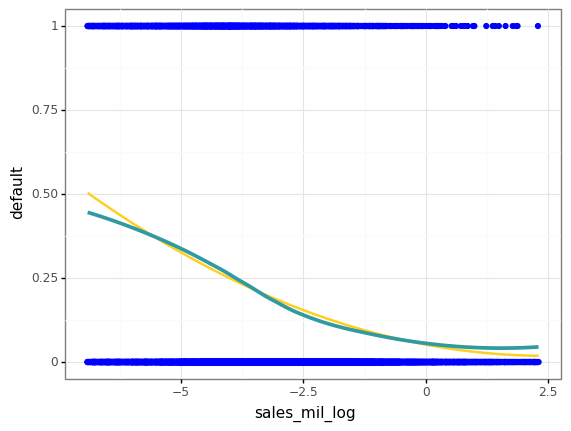

<ggplot: (146467604200)>

In [26]:
ggplot(data, aes(x = "sales_mil_log", y = "default")) + geom_point(
    color = 'blue') + geom_smooth(
    method='lm', formula='y ~ poly(x, degree=2)',  color=color[3], se = False) + geom_smooth(
    method = "loess", color=color[4], se = False, size=1.5, span=0.9) + labs(
    x="sales_mil_log", y="default"
) + theme_bw()

In [27]:
# Linear regressions

ols_s = smf.ols("default ~ sales_mil_log + sales_mil_log_sq", data = data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     752.7
Date:                Tue, 18 May 2021   Prob (F-statistic):          8.90e-317
Time:                        15:37:08   Log-Likelihood:                -10418.
No. Observations:               21723   AIC:                         2.084e+04
Df Residuals:                   21720   BIC:                         2.087e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0519      0.006  

In [29]:
########################################################################
# sales change
########################################################################
# Note: graphs not in book

# lowess
data['d1_sales_mil_log'].describe()

count    21723.000000
mean        -0.077675
std          0.842694
min         -6.889406
25%         -0.158513
50%          0.000000
75%          0.103433
max          7.880300
Name: d1_sales_mil_log, dtype: float64

C:\dev\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 56 rows containing missing values.


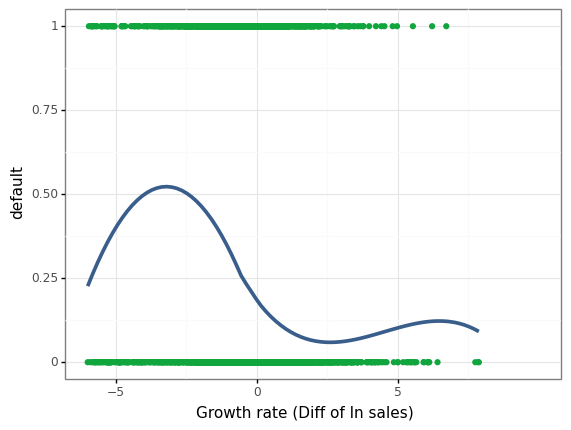

<ggplot: (146467717295)>

In [30]:
ggplot(data, aes(x = "d1_sales_mil_log", y = "default")) + geom_point(
    color=color[1]) + geom_smooth(
    method = "loess", color=color[0], se = False, size=1.5, span=0.9) + labs(
    x="Growth rate (Diff of ln sales)", y="default") + scale_x_continuous(
    limits=(-6, 10), breaks = seq(-5, 10, by = 5)
) + theme_bw() 
#saving?

In [31]:
# generate variables ---------------------------------------------------

data['flag_low_d1_sales_mil_log'] = np.where(data['d1_sales_mil_log'] < -1.5, 1, 0)
data['flag_high_d1_sales_mil_log'] = np.where(data['d1_sales_mil_log'] > 1.5, 1, 0)
data['d1_sales_mil_log_mod'] = np.where(data['d1_sales_mil_log'] < -1.5, -1.5, 
                                        np.where(data['d1_sales_mil_log'] > 1.5, 1.5, data['d1_sales_mil_log']))
data['d1_sales_mil_log_mod_sq'] = data['d1_sales_mil_log_mod']**2

In [32]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset = ['liq_assets_bs', 'foreign', 'ind'])

In [33]:
# drop missing
data = data.dropna(subset = ['age', 'foreign', 'material_exp_pl', 'm_region_loc'])
data['age'].describe()

count    19036.000000
mean         8.701828
std          6.924531
min          0.000000
25%          2.000000
50%          7.000000
75%         15.000000
max         34.000000
Name: age, dtype: float64

In [34]:
# drop unused factor levels
for col in data.select_dtypes(include=['category']).columns:
    data[col] = data[col].cat.remove_unused_categories()

C:\dev\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 1151 rows containing missing values.


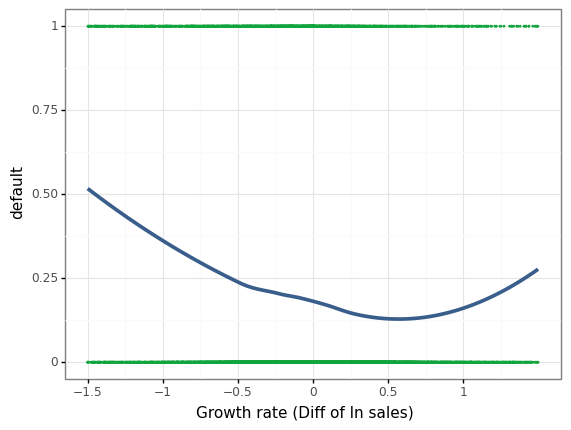

<ggplot: (146472771154)>

In [35]:
ggplot(data, aes(x = "d1_sales_mil_log", y = "default")) + geom_point(
    size = 0.1, color = color[1]) + geom_smooth(
    method = "loess", color = color[0], se = False, size=1.5, span=0.9) + labs(
    x="Growth rate (Diff of ln sales)", y="default") + scale_x_continuous(
    limits=(-1.5, 1.5), breaks = seq(-1.5, 1.5, by = 0.5)
) + theme_bw() 
#saving?

C:\dev\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 142 rows containing missing values.


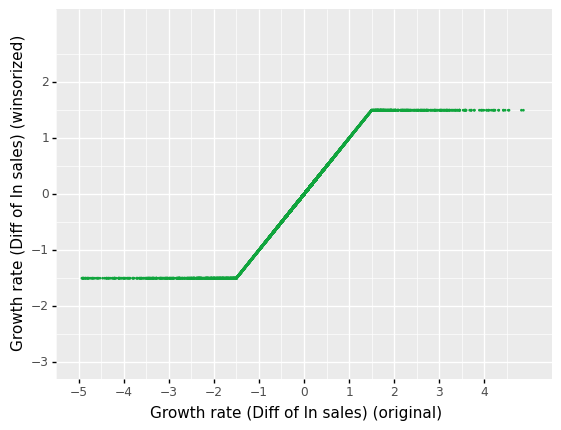

<ggplot: (146472774464)>

In [36]:
ggplot(data, aes(x = "d1_sales_mil_log", y = "d1_sales_mil_log_mod")) + geom_point(
    size = 0.1, color = color[1]) + labs(
    x="Growth rate (Diff of ln sales) (original)", y="Growth rate (Diff of ln sales) (winsorized)"
) + scale_x_continuous(limits=(-5, 5), breaks = seq(-5, 5, by = 1)
) + scale_y_continuous(limits=(-3, 3), breaks = seq(-3, 3, by = 1))

In [37]:
# check variables
# datasummary_skim(data, type="numeric")

#write_csv(data,paste0(data_out,"bisnode_firms_clean.csv"))
data.to_csv(data_out+"bisnode_firms_clean.csv",index=False)
#write_rds(data,paste0(data_out,"bisnode_firms_clean.rds"))